In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense,\
                                      Input, Embedding, LSTM,\
                                      Bidirectional, GRU, \
                                      GlobalMaxPooling1D, Conv1D
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from imblearn.over_sampling import SMOTE

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_json('drive/MyDrive/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [7]:
X_train_raw, X_test, y_train_raw, y_test = train_test_split(df.headline, df.is_sarcastic, train_size=.8)
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw, train_size=.8)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((18316,), (18316,), (4579,), (4579,), (5724,), (5724,))

### Text vectorization ( tokenization)

In [8]:
text_vectorizer = TextVectorization(max_tokens=None, # max number of words possible in the dictionary if a number is set, less common word would become <oov> out of vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int', # can be tf-idf
                                    output_sequence_length=None, # if non all sequences becomes as long as longest by adding 0s to front or end?, 50 means no more than 50 words
                                    pad_to_max_tokens=False #
                                    )

In [9]:
round(sum([len(i.split()) for i in X_train])/len(X_train))

10

In [10]:
max_vocab_length = 23000 # max no of word to have in vocab
max_length = 15 # how many tokens per tweet the model sees and uses

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length
                                    )

In [11]:
text_vectorizer.adapt(X_train) # adapt for tf instead of fit in sklearn

In [12]:
sample = 'There is a flood here help us!'
text_vectorizer(sample) ## puts the zeros at the end to get to 15 tokens

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([ 222,   11,    7, 6063,  379,  219,   40,    0,    0,    0,    0,
          0,    0,    0,    0])>

In [13]:
# choose a random sentence from train set
random_headline = np.random.choice(X_train)
print(f'Original tweet: {random_headline}\
        \n\nVectorized tweet:')
text_vectorizer(random_headline)

Original tweet: sexualized octogenarian flapper girl still earning living for someone        

Vectorized tweet:


<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([ 9121, 16437, 19732,   321,    69, 20366,   362,     6,   453,
           0,     0,     0,     0,     0,     0])>

In [14]:
# We set max tokens to be 10000, lets see how many words we actually have
words_in_vocab = text_vectorizer.get_vocabulary() #gets all the words
top_5 = words_in_vocab[:5] #most common words
bottom_5 = words_in_vocab[-5:] #least common words
print(f'Number of unique words :{len(words_in_vocab)}')
print(f'Most common words:{top_5}')
print(f'Least common words:{bottom_5}')

Number of unique words :23000
Most common words:['', '[UNK]', 'to', 'of', 'the']
Least common words:['arafats', 'arabic', 'araa', 'ar15', 'aquatic']


### Creating an Embedding using an Embedding Layer

-input_dim size of the vocabulary

-output_dim size of the output embedding layer

-input_length length of the sequences being passed to the embedding layer

In [15]:
embedding = Embedding(input_dim=max_vocab_length, # pre defined 10000 total number of words we allow
                      output_dim=128, #usually use powers of 2
                      input_length=max_length
                      )
embedding

In [16]:
random_sentence = np.random.choice(X_train)
print(f'Original tweet: \n {random_sentence})\
        \n\n Embedded version:')
      
# Embed the random tweet (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer(random_sentence))
sample_embed # shape is 15,128 15 because we have 15 tokens as input each input turned into a vector of 128

Original tweet: 
 ape footage causes brief three-and-a-half-minute interruption in channel-surfing)        

 Embedded version:


<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
array([[ 0.0108192 ,  0.0038358 , -0.04364262, ...,  0.01142993,
        -0.02530917, -0.00956578],
       [ 0.0262404 , -0.0065925 , -0.0084211 , ..., -0.03930124,
         0.00109185, -0.03764373],
       [ 0.02090425, -0.04334145,  0.03164167, ...,  0.02418296,
         0.04534347,  0.00780544],
       ...,
       [-0.01621753, -0.00032389,  0.03984599, ..., -0.00045942,
        -0.02526097, -0.04940602],
       [-0.01621753, -0.00032389,  0.03984599, ..., -0.00045942,
        -0.02526097, -0.04940602],
       [-0.01621753, -0.00032389,  0.03984599, ..., -0.00045942,
        -0.02526097, -0.04940602]], dtype=float32)>

In [17]:
SAVE_DIR = 'tensorboard'

In [18]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [19]:
def eval_model(y_true, y_pred):
  '''
  Calculates model accuracy, precision, recall and f1 score for a binary classification model
  '''

  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy':model_accuracy *100,
                   'precision':model_precision*100,
                   'recall':model_recall*100,
                   'f1':model_f1*100}
  return model_results

## Model0 Naive Bayes (Bernoulli)

In [20]:
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), #Turns text into numbers
                    ('clf', BernoulliNB()) #Model the numbers
])
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', BernoulliNB())])

In [21]:
Bernoulli_NB = model_0.score(X_val, y_val)
print(f'Bernoulli model accuracy: {Bernoulli_NB*100:.2f}%')

Bernoulli model accuracy: 83.62%


In [22]:
Bernoulli_preds = model_0.predict(X_val)

print(classification_report(y_val, Bernoulli_preds, digits=3))

              precision    recall  f1-score   support

           0      0.815     0.885     0.849      2376
           1      0.863     0.783     0.822      2203

    accuracy                          0.836      4579
   macro avg      0.839     0.834     0.835      4579
weighted avg      0.838     0.836     0.836      4579



In [23]:
Bernoulli_results = eval_model(y_val, Bernoulli_preds)
Bernoulli_results

{'accuracy': 83.62087792094344,
 'f1': 83.56038914561988,
 'precision': 83.83612904793154,
 'recall': 83.62087792094344}

## Model1 Naive Bayes (Multinomial)

In [24]:
model_1 = Pipeline([
                    ('tfidf', TfidfVectorizer()), #Turns text into numbers
                    ('clf', MultinomialNB()) #Model the numbers
])
model_1.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
Multinomial_NB = model_1.score(X_val, y_val)
print(f'Multinomial model accuracy: {Multinomial_NB*100:.2f}%')

Multinomial model accuracy: 82.62%


In [26]:
Multinomial_preds = model_1.predict(X_val)

print(classification_report(y_val, Multinomial_preds, digits=3))

              precision    recall  f1-score   support

           0      0.797     0.893     0.842      2376
           1      0.867     0.754     0.807      2203

    accuracy                          0.826      4579
   macro avg      0.832     0.824     0.824      4579
weighted avg      0.831     0.826     0.825      4579



In [27]:
Multinomial_results = eval_model(y_val, Multinomial_preds)
Multinomial_results

{'accuracy': 82.6162917667613,
 'f1': 82.50508813815486,
 'precision': 83.06169724367342,
 'recall': 82.6162917667613}

## Model2 Dense

In [28]:
inputs = Input(shape=(1,), dtype=tf.string) #inputs are 1 dimensional strings
x = text_vectorizer(inputs) # turns the input text into numbers
x = embedding(x) # turns numbers into embeddings\
x = GlobalAveragePooling1D()(x) # Condense the feature vector for each token to one vector
# x = GlobalMaxPooling1D()(x) # Condense the feature vector for each token to one vector
outputs = Dense(1,activation='sigmoid')(x) # Create the output layer, for binary outputs we used sigmoid activation
model2 = tf.keras.Model(inputs, outputs, name='Dense')
model2.summary()

Model: "Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           2944000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,944,129
Trainable params: 2,944,129
Non-train

In [29]:
model2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [30]:
filepath2 = 'dense_model'

checkpoint2 = ModelCheckpoint(filepath=filepath2,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks2 = [checkpoint2]

In [31]:
model2_history = model2.fit(X_train, y_train, 
                            epochs=5, 
                            validation_data=(X_val, y_val),
                            callbacks=[callbacks2, create_tensorboard_callback(SAVE_DIR,
                                                                   'dense_model_TB')])

Saving TensorBoard log files to: tensorboard/dense_model_TB/20220406-075424
Epoch 1/5
572/573 [============================>.] - ETA: 0s - loss: 0.5166 - accuracy: 0.7715
Epoch 1: val_accuracy improved from -inf to 0.83512, saving model to dense_model
INFO:tensorflow:Assets written to: dense_model/assets
573/573 [==============================] - 31s 52ms/step - loss: 0.5166 - accuracy: 0.7715 - val_loss: 0.3864 - val_accuracy: 0.8351
Epoch 2/5
573/573 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.8883
Epoch 2: val_accuracy improved from 0.83512 to 0.85150, saving model to dense_model
INFO:tensorflow:Assets written to: dense_model/assets
573/573 [==============================] - 30s 52ms/step - loss: 0.2935 - accuracy: 0.8883 - val_loss: 0.3425 - val_accuracy: 0.8515
Epoch 3/5
573/573 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9314
Epoch 3: val_accuracy improved from 0.85150 to 0.85368, saving model to dense_model
INFO:tensorflow:

{'accuracy': 85.3679842760428, 'precision': 85.37107702278158, 'recall': 85.3679842760428, 'f1': 85.3691232168385}


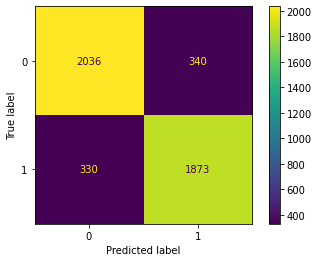

In [45]:
model2 = load_model(filepath2)
model2_pred_probs = model2.predict(X_val)
model2_predictions = tf.squeeze(tf.round(model2_pred_probs))
model2_results = eval_model(y_val, model2_predictions)
print(model2_results)
ConfusionMatrixDisplay.from_predictions(y_val, model2_predictions);

## Model3 LSTM

In [38]:
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)
outputs = Dense(1,activation='sigmoid')(x) # Create the output layer, for binary outputs we used sigmoid activation
model3 = tf.keras.Model(inputs, outputs, name='LSTM')

model3.compile(loss='binary_crossentropy', #for multiple class we use sparse_categorical_crossentropy
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model3.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           2944000   
                                                                 
 lstm_2 (LSTM)               (None, 15, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                              

In [39]:
filepath3 = 'LSTM_model'

checkpoint3 = ModelCheckpoint(filepath=filepath3,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks3 = [checkpoint3]

In [40]:
model3_history = model3.fit(X_train, y_train, 
                            epochs=5,
                            validation_data=(X_val, y_val),
                            callbacks=[callbacks3, create_tensorboard_callback(SAVE_DIR,
                                                                   'lstm_model_TB')])

Saving TensorBoard log files to: tensorboard/lstm_model_TB/20220406-080057
Epoch 1/5
573/573 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9759
Epoch 1: val_accuracy improved from -inf to 0.84123, saving model to LSTM_model


INFO:tensorflow:Assets written to: LSTM_model/assets


INFO:tensorflow:Assets written to: LSTM_model/assets


573/573 [==============================] - 69s 113ms/step - loss: 0.0801 - accuracy: 0.9759 - val_loss: 0.5845 - val_accuracy: 0.8412
Epoch 2/5
573/573 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9871
Epoch 2: val_accuracy did not improve from 0.84123
573/573 [==============================] - 39s 68ms/step - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.5739 - val_accuracy: 0.8373
Epoch 3/5
573/573 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9927
Epoch 3: val_accuracy did not improve from 0.84123
573/573 [==============================] - 40s 70ms/step - loss: 0.0237 - accuracy: 0.9927 - val_loss: 0.8171 - val_accuracy: 0.8290
Epoch 4/5
573/573 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9963
Epoch 4: val_accuracy did not improve from 0.84123
573/573 [==============================] - 40s 70ms/step - loss: 0.0142 - accuracy: 0.9963 - val_loss: 0.7588 - val_accuracy: 0.8307
Epoch 5/5
573/573 [==========

{'accuracy': 84.1231709980345, 'precision': 84.17467980294133, 'recall': 84.1231709980345, 'f1': 84.09920819332238}


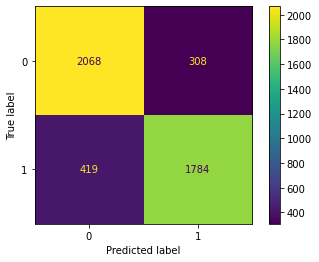

In [46]:
model3 = load_model(filepath3)
model3_pred_probs = model3.predict(X_val)
model3_predictions = tf.squeeze(tf.round(model3_pred_probs))
model3_results = eval_model(y_val, model3_predictions)
print(model3_results)
ConfusionMatrixDisplay.from_predictions(y_val, model3_predictions);

## Model4 GRU

In [47]:
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(64)(x)
outputs = Dense(1, activation='sigmoid')(x)
model4 = tf.keras.Model(inputs, outputs, name='GRU')
model4.compile(loss='binary_crossentropy', #for multiple class we use sparse_categorical_crossentropy
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model4.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           2944000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,981,313
Trainable params: 2,981,313
Non-trainable params: 0
_____________________________________________________

In [48]:
filepath4 = 'GRU_model'

checkpoint4 = ModelCheckpoint(filepath=filepath4,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks4 = [checkpoint4]

In [50]:
model4_history = model4.fit(X_train, y_train, 
                            epochs=5,
                            validation_data=(X_val, y_val),
                            callbacks=[callbacks4, create_tensorboard_callback(SAVE_DIR,
                                                                   'gru_model_TB')])

Saving TensorBoard log files to: tensorboard/gru_model_TB/20220406-081147
Epoch 1/5
573/573 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9826
Epoch 1: val_accuracy improved from -inf to 0.82922, saving model to GRU_model


INFO:tensorflow:Assets written to: GRU_model/assets


INFO:tensorflow:Assets written to: GRU_model/assets


573/573 [==============================] - 59s 98ms/step - loss: 0.0448 - accuracy: 0.9826 - val_loss: 0.8628 - val_accuracy: 0.8292
Epoch 2/5
573/573 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9978
Epoch 2: val_accuracy improved from 0.82922 to 0.83009, saving model to GRU_model


INFO:tensorflow:Assets written to: GRU_model/assets


INFO:tensorflow:Assets written to: GRU_model/assets


573/573 [==============================] - 45s 78ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 1.0568 - val_accuracy: 0.8301
Epoch 3/5
573/573 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9985
Epoch 3: val_accuracy did not improve from 0.83009
573/573 [==============================] - 43s 76ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 1.1843 - val_accuracy: 0.8120
Epoch 4/5
573/573 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9994
Epoch 4: val_accuracy did not improve from 0.83009
573/573 [==============================] - 40s 69ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 1.1510 - val_accuracy: 0.8192
Epoch 5/5
573/573 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9982
Epoch 5: val_accuracy did not improve from 0.83009
573/573 [==============================] - 50s 87ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 1.0106 - val_accuracy: 0.8152


{'accuracy': 83.00939069665866, 'precision': 83.02347820652656, 'recall': 83.00939069665866, 'f1': 83.01287045212247}


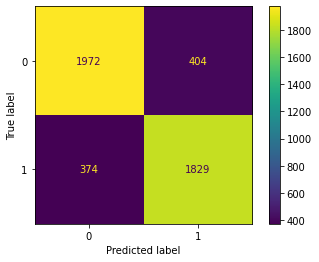

In [51]:
model4 = load_model(filepath4)
model4_pred_probs = model4.predict(X_val)
model4_predictions = tf.squeeze(tf.round(model4_pred_probs))
model4_results = eval_model(y_val, model4_predictions)
print(model4_results)
ConfusionMatrixDisplay.from_predictions(y_val, model4_predictions);

## Model5 Bidirectional RNN


In [52]:
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(GRU(64))(x)
outputs = Dense(1, activation='sigmoid')(x)
model5 = tf.keras.Model(inputs, outputs, name='bidirectional')
model5.compile(loss='binary_crossentropy', #for multiple class we use sparse_categorical_crossentropy
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model5.summary()

Model: "bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           2944000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                     

In [53]:
filepath5 = 'Bidirectional_model'

checkpoint5 = ModelCheckpoint(filepath=filepath5,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks5 = [checkpoint5]

In [54]:
model5_history = model5.fit(X_train, y_train, 
                            epochs=5,
                            validation_data=(X_val, y_val),
                            callbacks=[callbacks5, create_tensorboard_callback(SAVE_DIR,
                                                                   'Bidirectional_model_TB')])

Saving TensorBoard log files to: tensorboard/Bidirectional_model_TB/20220406-081621
Epoch 1/5
573/573 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9968
Epoch 1: val_accuracy improved from -inf to 0.82311, saving model to Bidirectional_model


INFO:tensorflow:Assets written to: Bidirectional_model/assets


INFO:tensorflow:Assets written to: Bidirectional_model/assets


573/573 [==============================] - 122s 194ms/step - loss: 0.0168 - accuracy: 0.9968 - val_loss: 1.1734 - val_accuracy: 0.8231
Epoch 2/5
573/573 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9992
Epoch 2: val_accuracy did not improve from 0.82311
573/573 [==============================] - 51s 90ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 1.2309 - val_accuracy: 0.8150
Epoch 3/5
573/573 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9996
Epoch 3: val_accuracy did not improve from 0.82311
573/573 [==============================] - 58s 101ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 1.5403 - val_accuracy: 0.8133
Epoch 4/5
573/573 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994
Epoch 4: val_accuracy did not improve from 0.82311
573/573 [==============================] - 78s 136ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 1.1121 - val_accuracy: 0.8133
Epoch 5/5
573/573 [=======

{'accuracy': 82.31054815461891, 'precision': 82.34623177716931, 'recall': 82.31054815461891, 'f1': 82.31607949787237}


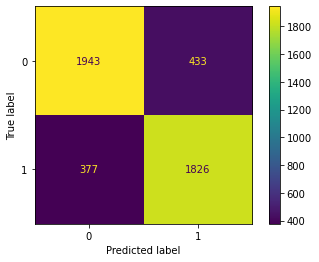

In [55]:
model5 = load_model(filepath5)
model5_pred_probs = model5.predict(X_val)
model5_predictions = tf.squeeze(tf.round(model5_pred_probs))
model5_results = eval_model(y_val, model5_predictions)
print(model5_results)
ConfusionMatrixDisplay.from_predictions(y_val, model5_predictions);

## Model6 Conv1D

In [56]:
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(64, kernel_size=3, activation='relu',padding='same',strides=1)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(1, activation='sigmoid')(x)
model6 = tf.keras.Model(inputs, outputs, name='CNN1D')
model6.compile(loss='binary_crossentropy', #for multiple class we use sparse_categorical_crossentropy
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model6.summary()

Model: "CNN1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           2944000   
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            24640     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 1)                 65    

In [57]:
filepath6 = 'CNN1D_model'

checkpoint6 = ModelCheckpoint(filepath=filepath6,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks6 = [checkpoint6]

In [58]:
model6_history = model6.fit(X_train, y_train, 
                            epochs=5,
                            validation_data=(X_val, y_val),
                            callbacks=[callbacks6, create_tensorboard_callback(SAVE_DIR,
                                                                   'CNN1D_model_TB')])

Saving TensorBoard log files to: tensorboard/CNN1D_model_TB/20220406-082456
Epoch 1/5
573/573 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9811
Epoch 1: val_accuracy improved from -inf to 0.79908, saving model to CNN1D_model
INFO:tensorflow:Assets written to: CNN1D_model/assets


INFO:tensorflow:Assets written to: CNN1D_model/assets


573/573 [==============================] - 33s 56ms/step - loss: 0.0628 - accuracy: 0.9811 - val_loss: 0.9142 - val_accuracy: 0.7991
Epoch 2/5
573/573 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9949
Epoch 2: val_accuracy did not improve from 0.79908
573/573 [==============================] - 40s 69ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 1.1564 - val_accuracy: 0.7936
Epoch 3/5
573/573 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9992
Epoch 3: val_accuracy did not improve from 0.79908
573/573 [==============================] - 35s 60ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 1.3711 - val_accuracy: 0.7899
Epoch 4/5
573/573 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9999
Epoch 4: val_accuracy did not improve from 0.79908
573/573 [==============================] - 34s 59ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 1.4942 - val_accuracy: 0.7914
Epoch 5/5
573/573 [===========

{'accuracy': 79.90827691635728, 'precision': 79.92473856913878, 'recall': 79.90827691635728, 'f1': 79.91260461467121}


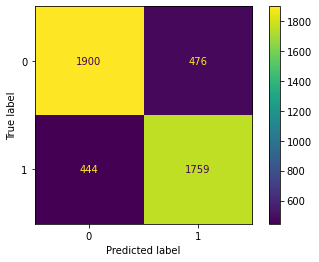

In [59]:
model6 = load_model(filepath6)
model6_pred_probs = model6.predict(X_val)
model6_predictions = tf.squeeze(tf.round(model6_pred_probs))
model6_results = eval_model(y_val, model6_predictions)
print(model6_results)
ConfusionMatrixDisplay.from_predictions(y_val, model6_predictions);

## Model7 Transfer Learning - USE

In [60]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False, # Means we keep the weights pretrained instean of reseting
                                        name='USE') #Universal Sentence Encoder

In [61]:
model7 = Sequential([sentence_encoder_layer,
                     Dense(64, activation='relu'),
                     Dense(1, activation='sigmoid')
                              
], name='TL_USE')

# Compile the model
model7.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model7.summary()

Model: "TL_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [62]:
filepath7 = 'TL_USE_model'

checkpoint7 = ModelCheckpoint(filepath=filepath7,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks7 = [checkpoint7]

In [63]:
model7_history = model7.fit(X_train, y_train, 
                            epochs=10,
                            validation_data=(X_val, y_val),
                            callbacks=[callbacks7, create_tensorboard_callback(SAVE_DIR,
                                                                   'TL_USE_model_TB')])

Saving TensorBoard log files to: tensorboard/TL_USE_model_TB/20220406-082909
Epoch 1/10
573/573 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.7625
Epoch 1: val_accuracy improved from -inf to 0.78489, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 28s 41ms/step - loss: 0.5056 - accuracy: 0.7625 - val_loss: 0.4571 - val_accuracy: 0.7849
Epoch 2/10
573/573 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.7935
Epoch 2: val_accuracy improved from 0.78489 to 0.79209, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 27s 48ms/step - loss: 0.4406 - accuracy: 0.7935 - val_loss: 0.4399 - val_accuracy: 0.7921
Epoch 3/10
570/573 [============================>.] - ETA: 0s - loss: 0.4252 - accuracy: 0.8013
Epoch 3: val_accuracy improved from 0.79209 to 0.79865, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 21s 37ms/step - loss: 0.4252 - accuracy: 0.8014 - val_loss: 0.4310 - val_accuracy: 0.7986
Epoch 4/10
570/573 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8089
Epoch 4: val_accuracy improved from 0.79865 to 0.80563, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 24s 43ms/step - loss: 0.4113 - accuracy: 0.8090 - val_loss: 0.4203 - val_accuracy: 0.8056
Epoch 5/10
569/573 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.8184
Epoch 5: val_accuracy did not improve from 0.80563
573/573 [==============================] - 9s 15ms/step - loss: 0.3970 - accuracy: 0.8180 - val_loss: 0.4123 - val_accuracy: 0.8043
Epoch 6/10
570/573 [============================>.] - ETA: 0s - loss: 0.3821 - accuracy: 0.8265
Epoch 6: val_accuracy improved from 0.80563 to 0.81568, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 20s 35ms/step - loss: 0.3819 - accuracy: 0.8266 - val_loss: 0.4019 - val_accuracy: 0.8157
Epoch 7/10
572/573 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8352
Epoch 7: val_accuracy did not improve from 0.81568
573/573 [==============================] - 8s 14ms/step - loss: 0.3661 - accuracy: 0.8352 - val_loss: 0.3937 - val_accuracy: 0.8157
Epoch 8/10
572/573 [============================>.] - ETA: 0s - loss: 0.3516 - accuracy: 0.8435
Epoch 8: val_accuracy improved from 0.81568 to 0.82048, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 20s 34ms/step - loss: 0.3518 - accuracy: 0.8434 - val_loss: 0.3861 - val_accuracy: 0.8205
Epoch 9/10
572/573 [============================>.] - ETA: 0s - loss: 0.3376 - accuracy: 0.8512
Epoch 9: val_accuracy improved from 0.82048 to 0.82485, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 25s 44ms/step - loss: 0.3378 - accuracy: 0.8510 - val_loss: 0.3834 - val_accuracy: 0.8249
Epoch 10/10
573/573 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8578
Epoch 10: val_accuracy improved from 0.82485 to 0.82594, saving model to TL_USE_model


INFO:tensorflow:Assets written to: TL_USE_model/assets


INFO:tensorflow:Assets written to: TL_USE_model/assets


573/573 [==============================] - 26s 45ms/step - loss: 0.3239 - accuracy: 0.8578 - val_loss: 0.3813 - val_accuracy: 0.8259


{'accuracy': 82.59445293732256, 'precision': 82.61071183001229, 'recall': 82.59445293732256, 'f1': 82.59829172888051}


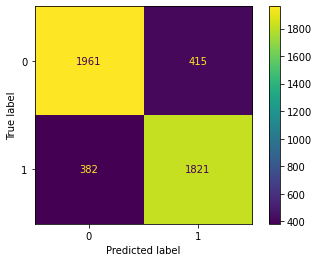

In [69]:
model7 = load_model(filepath7)
model7_pred_probs = model7.predict(X_val)
model7_predictions = tf.squeeze(tf.round(model7_pred_probs))
model7_results = eval_model(y_val, model7_predictions)
print(model7_results)
ConfusionMatrixDisplay.from_predictions(y_val, model7_predictions);

# Comparing Models

In [70]:
all_model_results = pd.DataFrame({'Naive Bayes (Multinomial)':Multinomial_results,
                                  'Naive Bayes (Bernoulli)':Bernoulli_results,
                                  'Dense':model3_results,
                                  'LSTM':model4_results,
                                  'GRU':model4_results,
                                  'Bidirectional':model5_results,
                                  'Conv1D':model6_results,
                                  'TF-HUB USE':model7_results})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
Naive Bayes (Multinomial),82.616292,83.061697,82.616292,82.505088
Naive Bayes (Bernoulli),83.620878,83.836129,83.620878,83.560389
Dense,84.123171,84.174680,84.123171,84.099208
LSTM,83.009391,83.023478,83.009391,83.012870
GRU,83.009391,83.023478,83.009391,83.012870
Bidirectional,82.310548,82.346232,82.310548,82.316079
Conv1D,79.908277,79.924739,79.908277,79.912605
TF-HUB USE,82.594453,82.610712,82.594453,82.598292


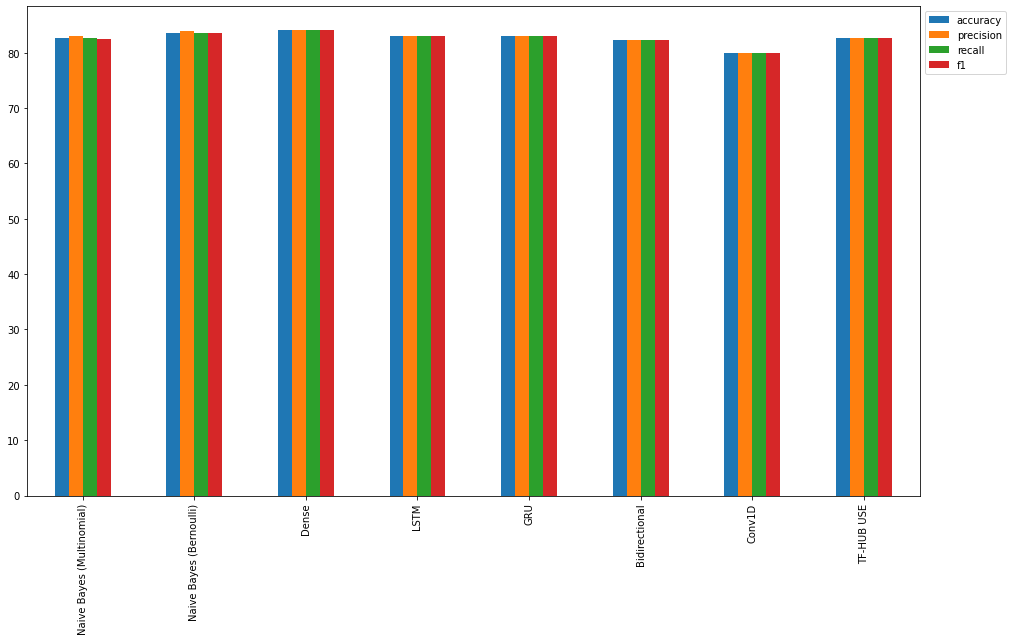

In [71]:
all_model_results.plot(kind='bar',figsize=(16,9)).legend(bbox_to_anchor=(1,1));

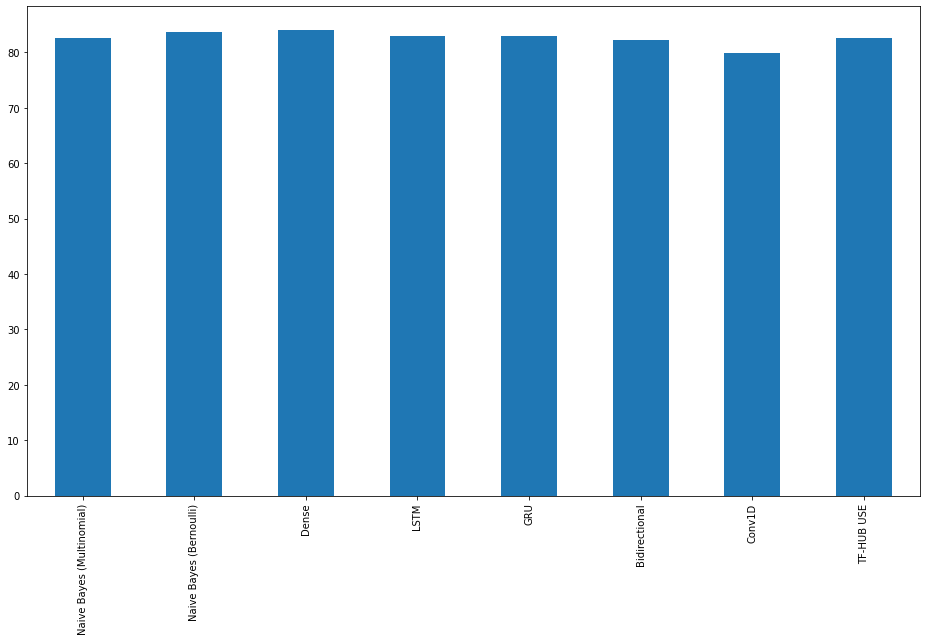

In [73]:
all_model_results['recall'].plot(kind='bar',figsize=(16,9));

## Test Data Scores

{'accuracy': 84.15443745632425, 'precision': 84.21355975302471, 'recall': 84.15443745632425, 'f1': 84.13118978963337}


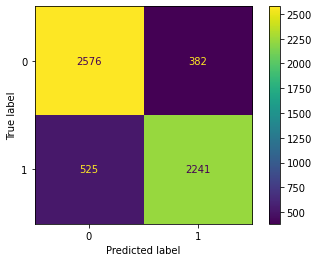

In [79]:
model3_pred_probs_test = model3.predict(X_test)
model3_predictions_test = tf.squeeze(tf.round(model3_pred_probs_test))
model3_results_test = eval_model(y_test, model3_predictions_test)
ConfusionMatrixDisplay.from_predictions(y_test, model3_predictions_test);
print(model3_results_test)


## Tensorboard - Dense Model (Best Model)

In [83]:
!tensorboard dev upload --logdir ./tensorboard/ \
  --name 'Sarcasm NLP Analysis' \
  --description 'NLP Classification project of news headlines' \
  --one_shot

2022-04-06 08:46:51.966708: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Aw

### Tensorboard Link
https://tensorboard.dev/experiment/lDzFNLqJQoi1fDIjouMtrQ/

In [87]:
model3.predict(['Very good job on that terrible report'])

array([[0.9996041]], dtype=float32)

### Model is pretty sure this is a sarcastic headline

In [89]:
model3.predict(['I am happy for the results'])

array([[0.00199085]], dtype=float32)

### Model seems to be doing a good job on both ends I'd say

In [99]:
!zip -r /content/file.zip /content/GRU_model/
!zip -r /content/file.zip /content/CNN1D_model/
!zip -r /content/file.zip /content/Bidirectional_model/
!zip -r /content/file.zip /content/LSTM_model/
!zip -r /content/file.zip /content/TL_USE_model/
!zip -r /content/file.zip /content/tensorboard/
files.download("/content/file.zip")

  adding: content/LSTM_model/ (stored 0%)
  adding: content/LSTM_model/assets/ (stored 0%)
  adding: content/LSTM_model/variables/ (stored 0%)
  adding: content/LSTM_model/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: content/LSTM_model/variables/variables.index (deflated 64%)
  adding: content/LSTM_model/keras_metadata.pb (deflated 89%)
  adding: content/LSTM_model/saved_model.pb (deflated 85%)
  adding: content/TL_USE_model/ (stored 0%)
  adding: content/TL_USE_model/assets/ (stored 0%)
  adding: content/TL_USE_model/variables/ (stored 0%)
  adding: content/TL_USE_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/TL_USE_model/variables/variables.index (deflated 78%)
  adding: content/TL_USE_model/keras_metadata.pb (deflated 84%)
  adding: content/TL_USE_model/saved_model.pb (deflated 67%)
  adding: content/tensorboard/ (stored 0%)
  adding: content/tensorboard/dense_model/ (stored 0%)
  adding: content/tensorboard/dense_model/20220406-073

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>